In [1]:
from hmc_u1 import HMC_U1
from field_transformations import manual_field_transformation
from nn_model import NNFieldTransformation
from utils import plot_results

In [2]:
# Parameters
lattice_size = 10
beta = 2.0
n_steps = 20
step_size = 0.01
n_iterations = 1000

100%|██████████| 1000/1000 [00:00<00:00, 5579.04it/s]


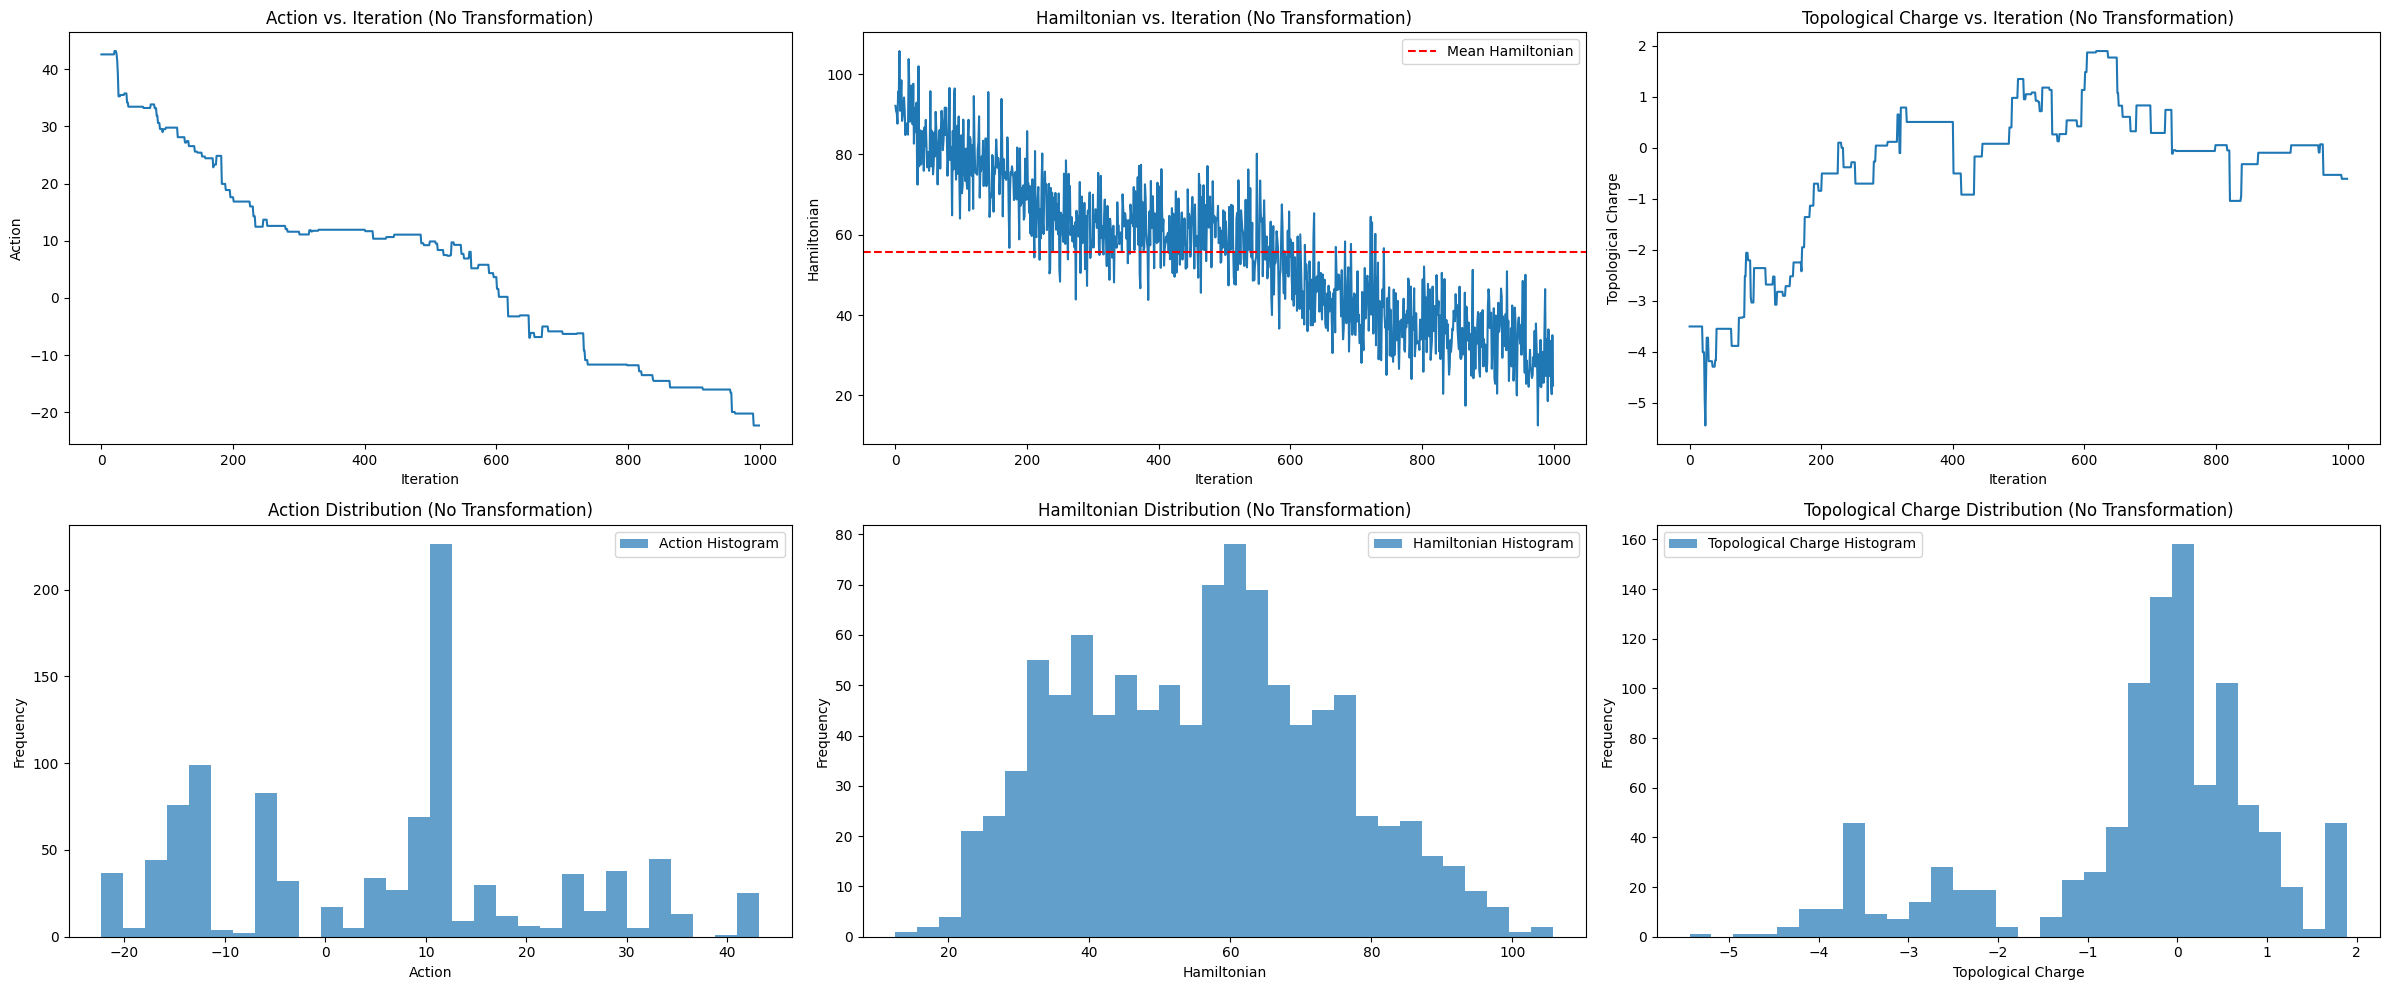

Final action (no transformation): -22.2907
Acceptance rate (no transformation): 0.0910
Final topological charge (no transformation): -0.6081


In [3]:
# Run HMC without field transformation
hmc = HMC_U1(lattice_size, beta, n_steps, step_size)
final_config, actions, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations)
plot_results(actions, topological_charges, hamiltonians, title_suffix="(No Transformation)")

print(f"Final action (no transformation): {actions[-1]:.4f}")
print(f"Acceptance rate (no transformation): {acceptance_rate:.4f}")
print(f"Final topological charge (no transformation): {topological_charges[-1]:.4f}")

100%|██████████| 1000/1000 [00:00<00:00, 5401.45it/s]


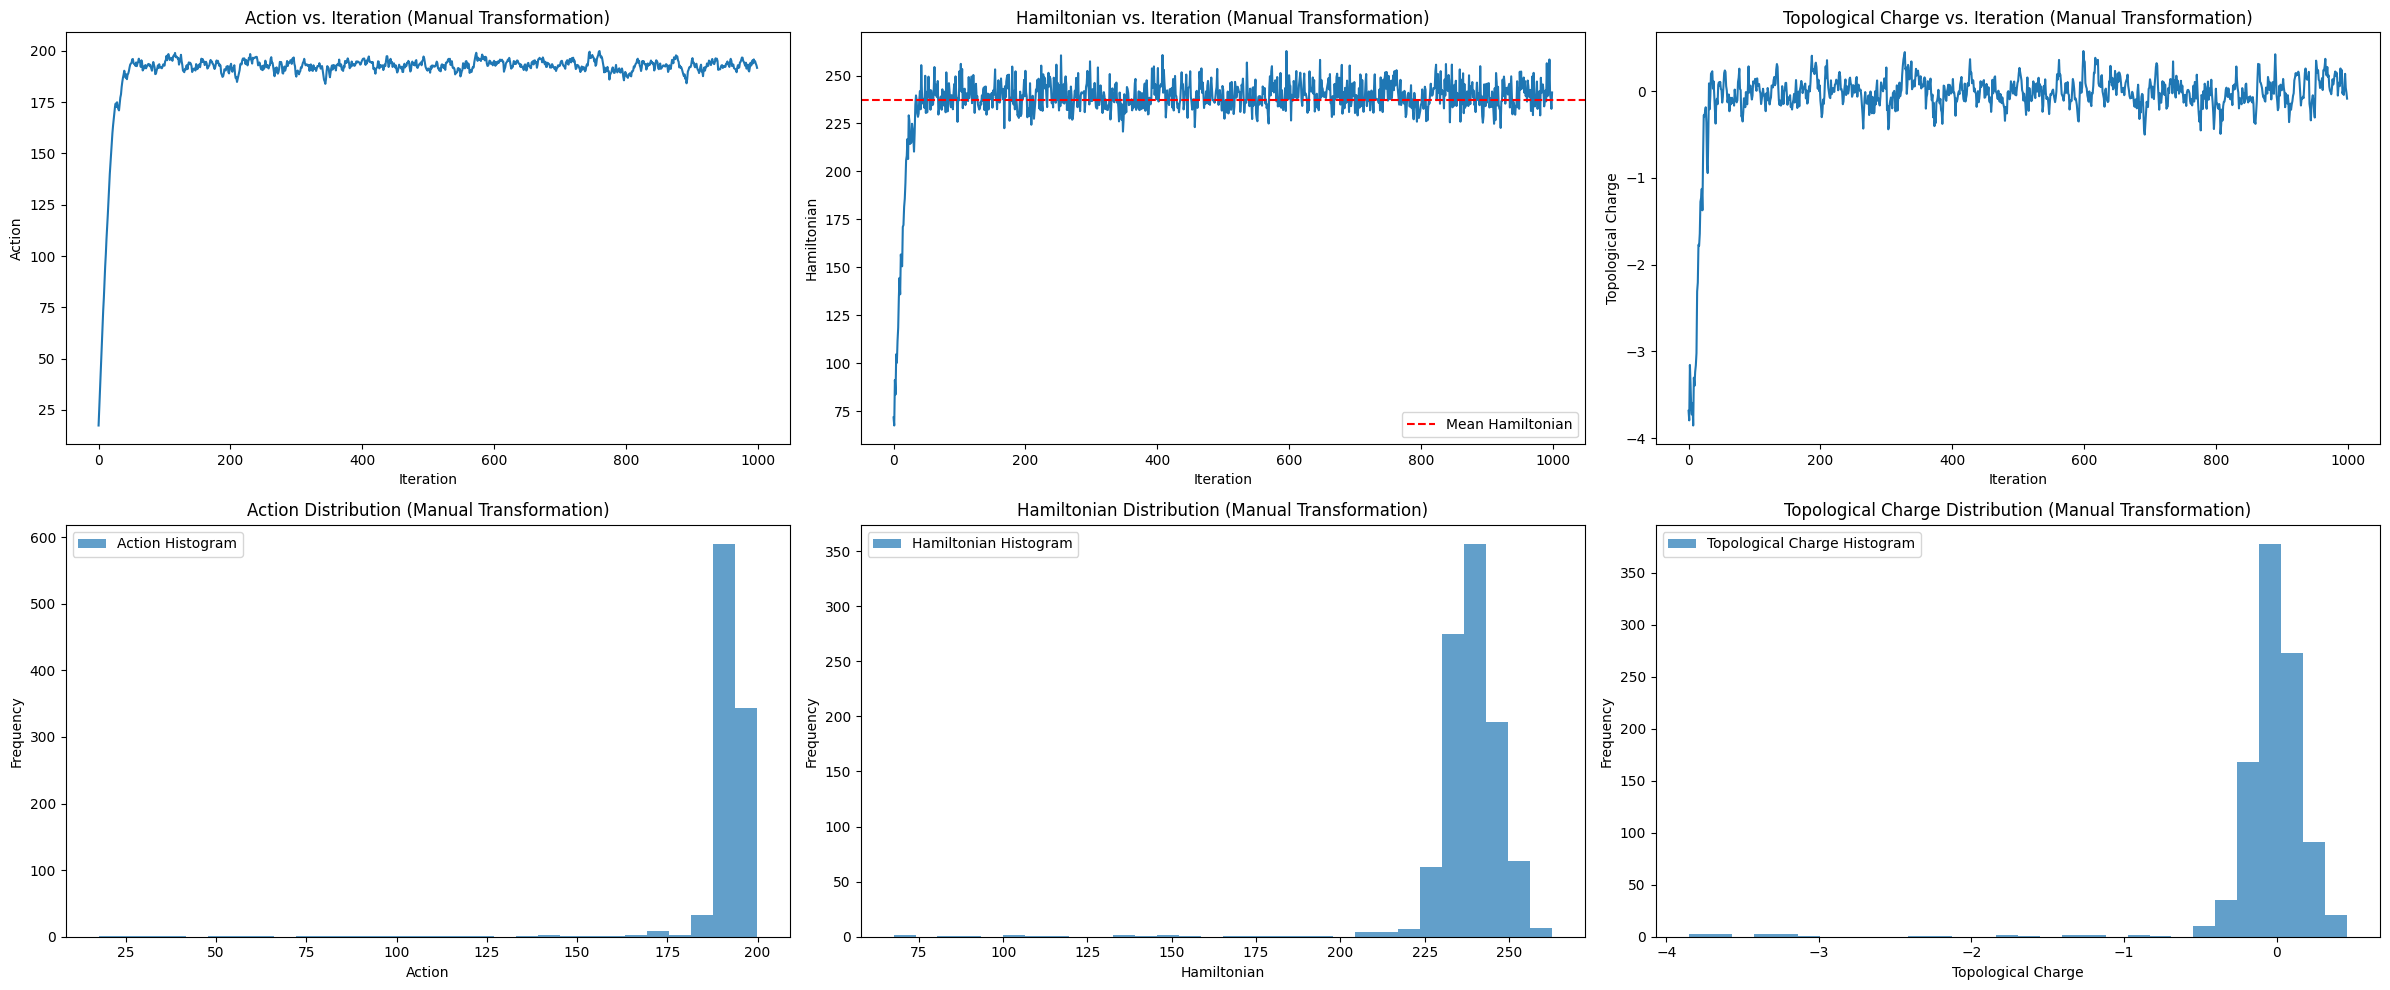

Final action (manual transformation): 191.6822
Acceptance rate (manual transformation): 0.9710
Final topological charge (manual transformation): -0.0857


In [4]:
# Run HMC with manual field transformation
final_config_manual, actions_manual, acceptance_rate_manual, topological_charges_manual, hamiltonians_manual = hmc.run(n_iterations, field_transformation=manual_field_transformation)
plot_results(actions_manual, topological_charges_manual, hamiltonians_manual, title_suffix="(Manual Transformation)")

print(f"Final action (manual transformation): {actions_manual[-1]:.4f}")
print(f"Acceptance rate (manual transformation): {acceptance_rate_manual:.4f}")
print(f"Final topological charge (manual transformation): {topological_charges_manual[-1]:.4f}")

100%|██████████| 1000/1000 [00:00<00:00, 3187.87it/s]


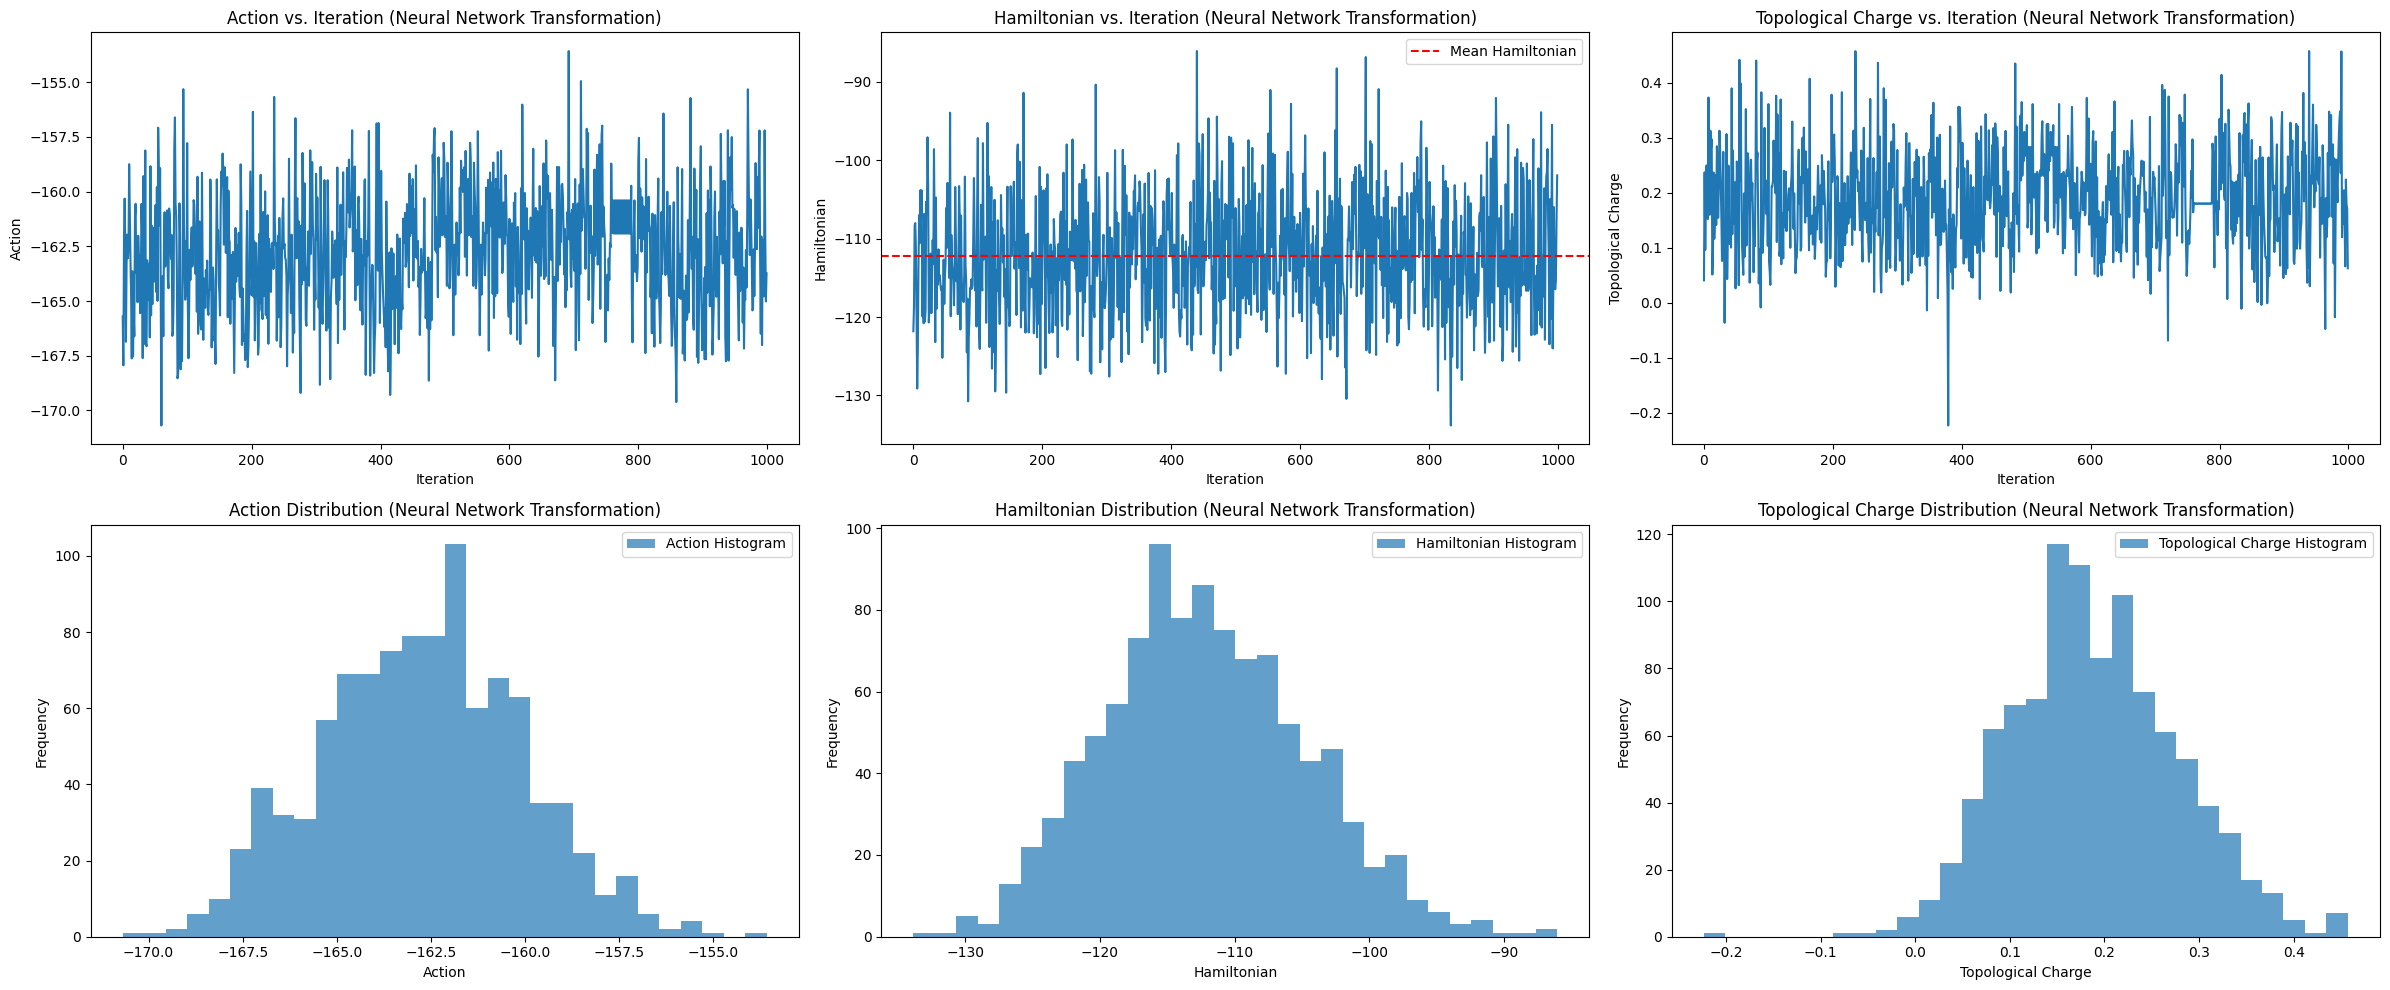

Final action (neural network transformation): -163.7321
Acceptance rate (neural network transformation): 0.0130
Final topological charge (neural network transformation): 0.0626


In [5]:
# Run HMC with neural network transformation
nn_transformation = NNFieldTransformation(lattice_size)
nn_transformation.train(hmc, n_iterations=500)
final_config_nn, actions_nn, acceptance_rate_nn, topological_charges_nn, hamiltonians_nn = hmc.run(n_iterations, field_transformation=nn_transformation)
plot_results(actions_nn, topological_charges_nn, hamiltonians_nn, title_suffix="(Neural Network Transformation)")

print(f"Final action (neural network transformation): {actions_nn[-1]:.4f}")
print(f"Acceptance rate (neural network transformation): {acceptance_rate_nn:.4f}")
print(f"Final topological charge (neural network transformation): {topological_charges_nn[-1]:.4f}")